In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import time


data_df = pd.read_csv('/content/drive/MyDrive/TCGA/data.csv')
labels_df = pd.read_csv('/content/drive/MyDrive/TCGA/labels.csv')



In [95]:
#  the first column is the column ID and should be set as the index
data_df.set_index(data_df.columns[0], inplace=True)
labels_df.set_index(labels_df.columns[0], inplace=True)

In [96]:
# Check for null values in the data
print("Null values in data:")
print(data_df.isnull().sum().sum())

print("\nNull values in labels:")
print(labels_df.isnull().sum().sum())

Null values in data:
0

Null values in labels:
0


In [97]:
X_train, X_test, y_train, y_test = train_test_split(data_df, labels_df, test_size=0.2, random_state=42)


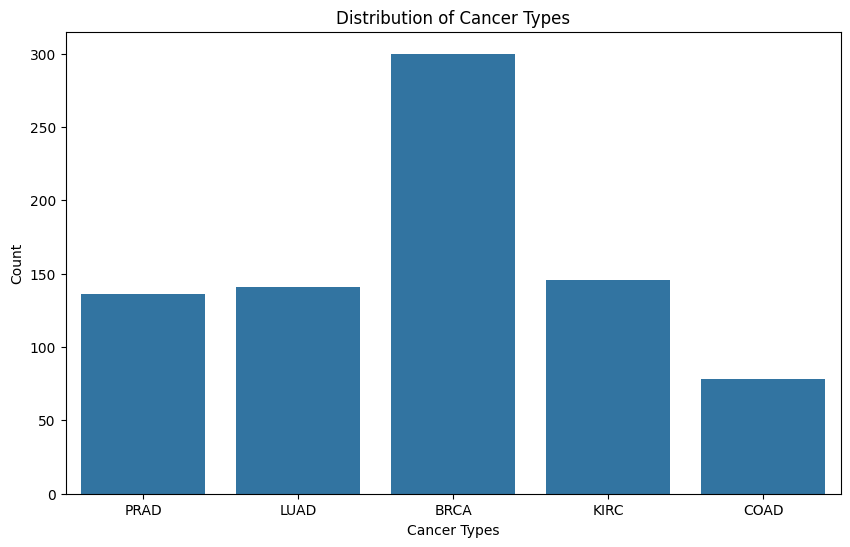

In [98]:
plt.figure(figsize=(10, 6))
sns.countplot(x=labels_df.iloc[:, 0])
plt.title('Distribution of Cancer Types')
plt.xlabel('Cancer Types')
plt.ylabel('Count')
plt.show()



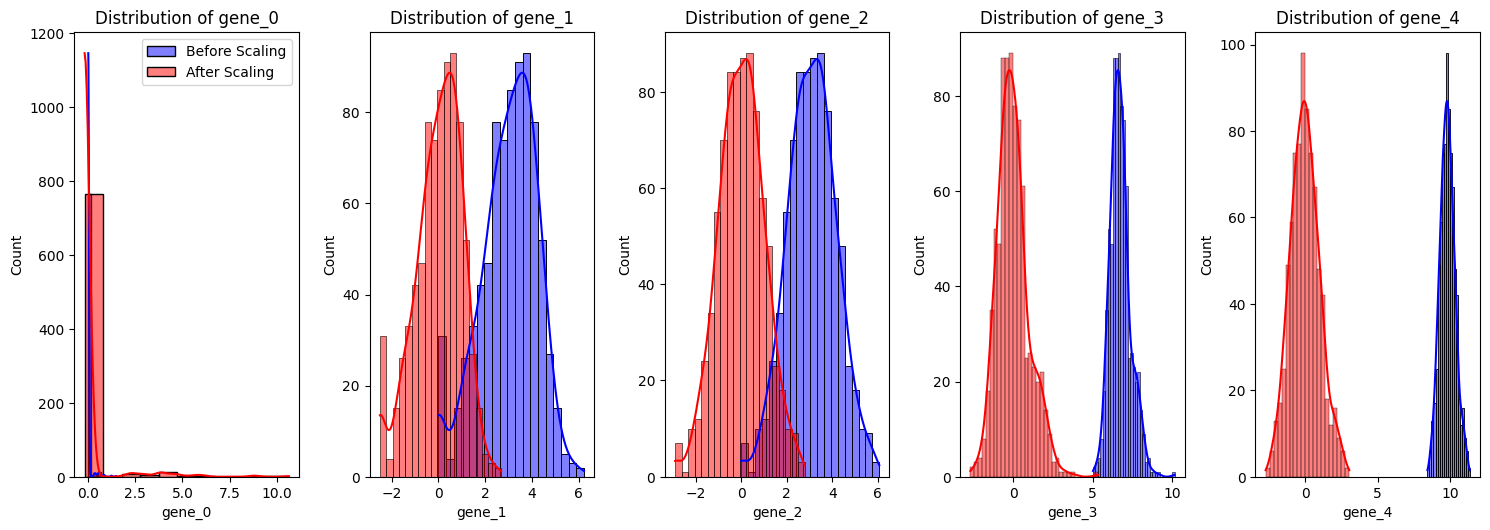

In [99]:
features = X_train.columns[:5]  # Select the first 5 features for demonstration

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(data_scaled, columns=data_df.columns, index=data_df.index)


# Plot histograms before and after scaling
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 5, i)
    sns.histplot(data_df[feature], kde=True, color='blue', label='Before Scaling')
    sns.histplot(X_train_scaled_df[feature], kde=True, color='red', label='After Scaling')
    plt.title(f'Distribution of {feature}')
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.show()


In [100]:
X_train_scaled.shape

(640, 20531)

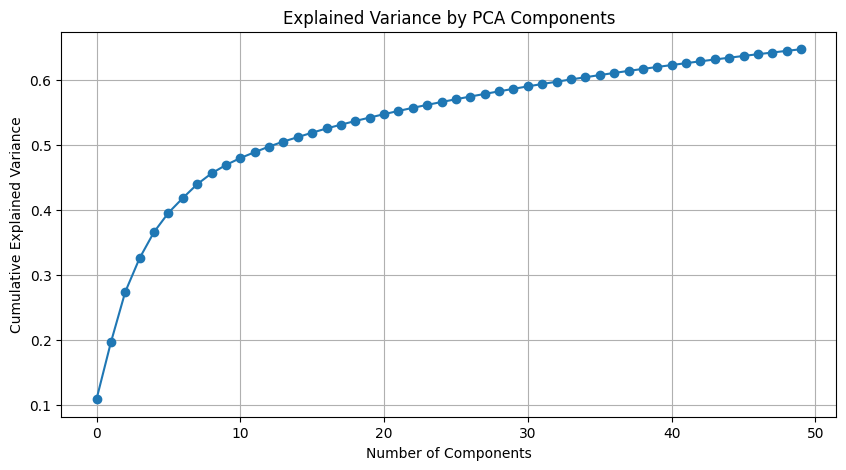

In [101]:
# Apply PCA with 50 components
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [102]:
# Transform the test data
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


In [103]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

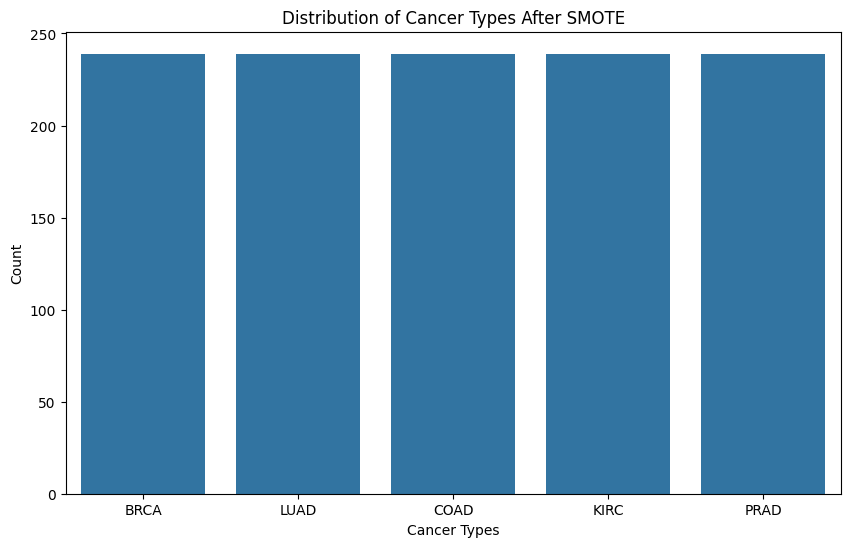

In [104]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled.iloc[:, 0])
plt.title('Distribution of Cancer Types After SMOTE')
plt.xlabel('Cancer Types')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best hyperparameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test accuracy: 0.9937888198757764
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        61
        COAD       1.00      1.00      1.00        17
        KIRC       1.00      0.96      0.98        25
        LUAD       1.00      1.00      1.00        29
        PRAD       1.00      1.00      1.00        29

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161

[[61  0  0  0  0]
 [ 0 17  0  0  0]
 [ 1  0 24  0  0]
 [ 0  0  0 29  0]
 [ 0  0  0  0 29]]
Time taken for training: 456.3798520565033


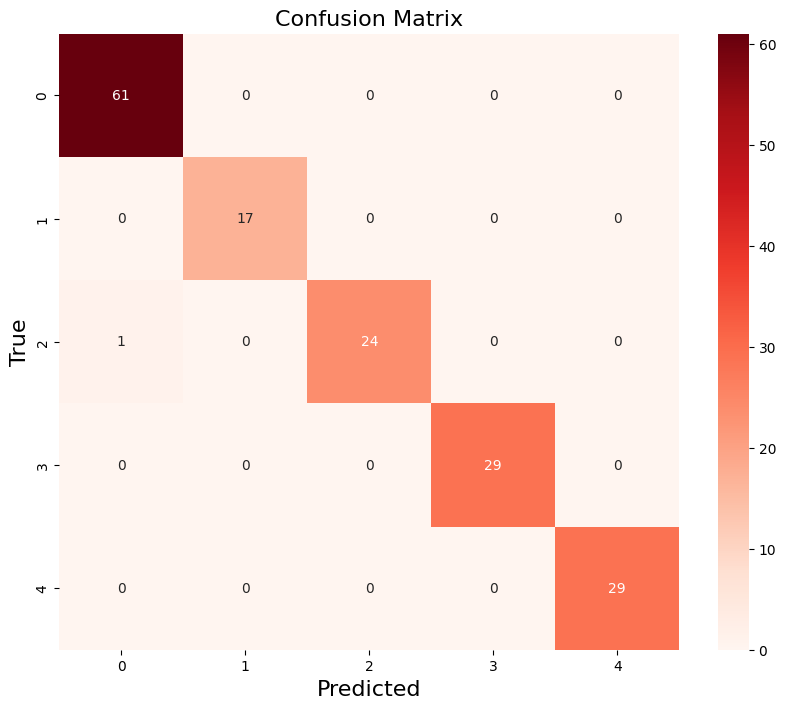

In [113]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5)
start_time = time.time()
grid_search.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

# Get the best model
best_rf = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = best_rf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the time taken for training
print("Time taken for training:", end_time - start_time)
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

# Add labels and title
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)
plt.title("Confusion Matrix", fontsize=16)

# Show the heatmap
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best hyperparameters:
{'learning_rate': 0.5, 'n_estimators': 150}
Test accuracy: 0.8509316770186336
              precision    recall  f1-score   support

        BRCA       1.00      0.74      0.85        61
        COAD       1.00      0.94      0.97        17
        KIRC       1.00      0.76      0.86        25
        LUAD       0.55      1.00      0.71        29
        PRAD       1.00      0.97      0.98        29

    accuracy                           0.85       161
   macro avg       0.91      0.88      0.87       161
weighted avg       0.92      0.85      0.86       161

[[45  0  0 16  0]
 [ 0 16  0  1  0]
 [ 0  0 19  6  0]
 [ 0  0  0 29  0]
 [ 0  0  0  1 28]]
Time taken for training: 53.12898898124695


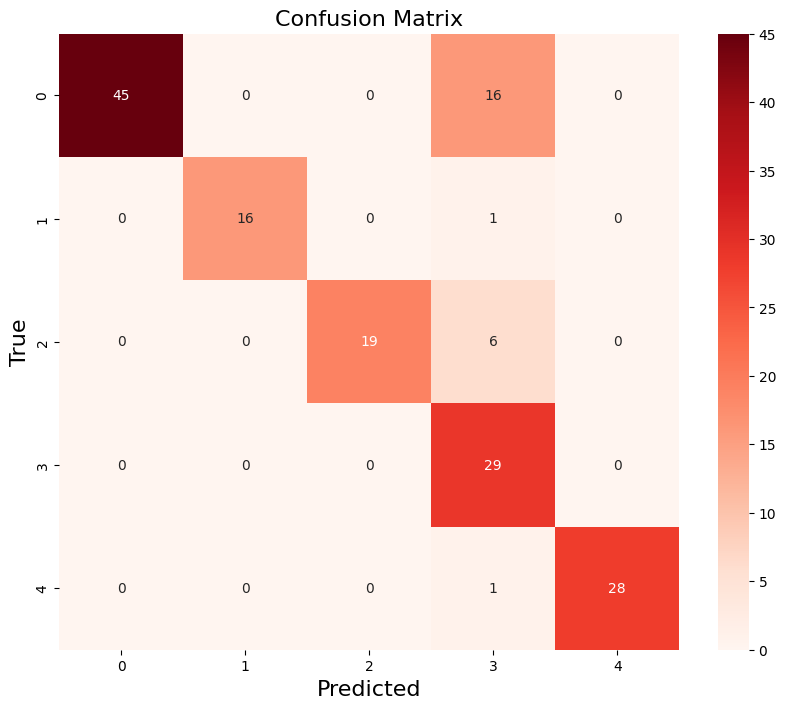

In [106]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


# Define the AdaBoost classifier
ada = AdaBoostClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(ada, param_grid, cv=5)
start_time = time.time()
grid_search.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

# Get the best model
best_ada = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = best_ada.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the time taken for training
print("Time taken for training:", end_time - start_time)


# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

# Add labels and title
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)
plt.title("Confusion Matrix", fontsize=16)

# Show the heatmap
plt.show()



Best hyperparameters:
{'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}
Test accuracy: 0.9813664596273292
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        61
           1       1.00      0.94      0.97        17
           2       1.00      0.96      0.98        25
           3       0.97      1.00      0.98        29
           4       1.00      0.97      0.98        29

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161

[[61  0  0  0  0]
 [ 0 16  0  1  0]
 [ 1  0 24  0  0]
 [ 0  0  0 29  0]
 [ 1  0  0  0 28]]
Time taken for training: 392.3361780643463


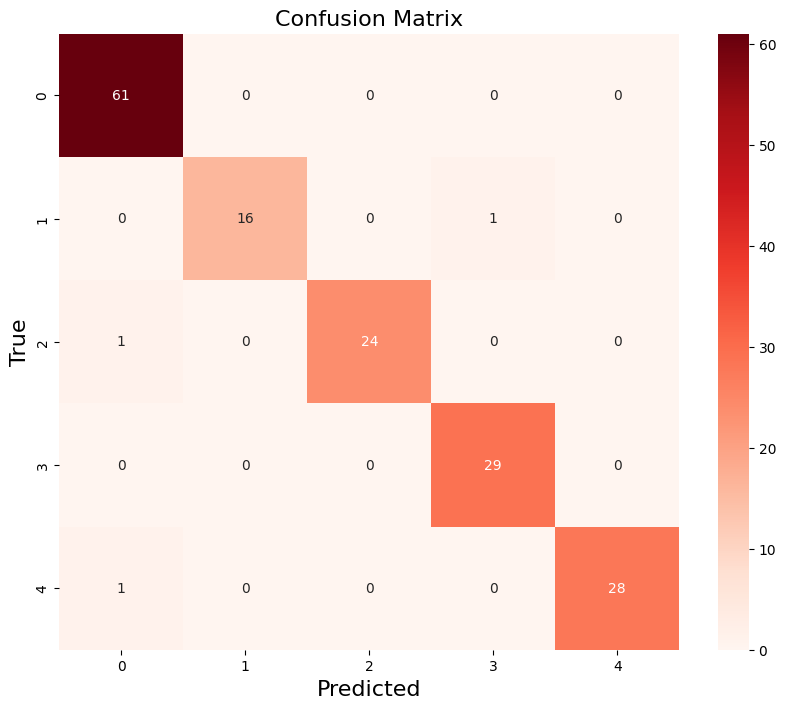

In [107]:
from sklearn.preprocessing import LabelEncoder


from xgboost import XGBClassifier
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(y_train_resampled.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

# Define the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [None, 5, 10],
    'min_child_weight': [1, 3, 5]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(xgb, param_grid, cv=5)
start_time = time.time()
grid_search.fit(X_train_resampled, labels_encoded)
end_time = time.time()

# Get the best model
best_xgb = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = best_xgb.predict(X_test_pca)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Test accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test_encoded, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test_encoded, y_pred))

# Print the time taken for training
print("Time taken for training:", end_time - start_time)


# Get the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

# Add labels and title
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)
plt.title("Confusion Matrix", fontsize=16)

# Show the heatmap
plt.show()



In [108]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train_resampled_onehot = onehot_encoder.fit_transform(y_train_resampled)
y_test_onehot = onehot_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/5
16/16 [==============================] - 3s 72ms/step - loss: 1.2051 - accuracy: 0.6230 - val_loss: 0.2452 - val_accuracy: 0.9375
Epoch 2/5
16/16 [==============================] - 1s 56ms/step - loss: 1.0891 - accuracy: 0.7402 - val_loss: 0.1038 - val_accuracy: 0.9688
Epoch 3/5
16/16 [==============================] - 1s 54ms/step - loss: 0.7816 - accuracy: 0.7969 - val_loss: 0.0189 - val_accuracy: 0.9922
Epoch 4/5
16/16 [==============================] - 1s 51ms/step - loss: 0.4410 - accuracy: 0.8711 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 5/5
6/6 [==============================] - 0s 19ms/step - loss: 0.0232 - accuracy: 0.9938
Test loss: 0.023184100165963173
Test accuracy: 0.9937888383865356
Time taken for training: 7.189058303833008
6/6 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        61
        COAD       1.00      1.00      1.00        17
        KIRC       1

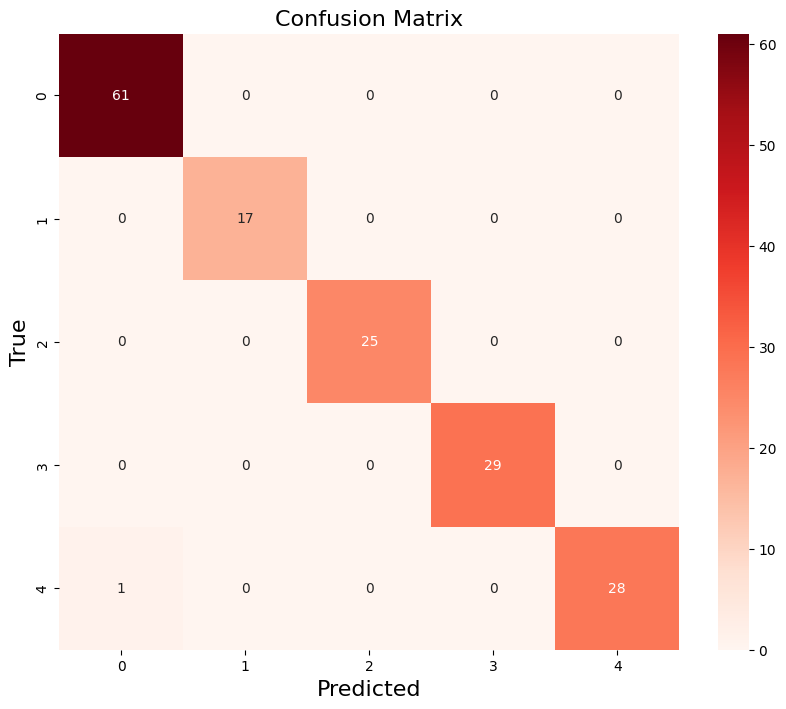

In [109]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_resampled_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))


# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Increased dropout rate to prevent overfitting
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))  # Added another dropout layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Introduce early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data
time_start = time.time()
model.fit(X_train_scaled, y_train_resampled_onehot, epochs=5, batch_size=32,
          validation_split=0.2, callbacks=[early_stopping])
end_time = time.time()



# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
# Print the time taken for training
print("Time taken for training:", end_time - time_start)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Convert predictions and true labels back to original form
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

# Get the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

# Add labels and title
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("True", fontsize=16)
plt.title("Confusion Matrix", fontsize=16)

# Show the heatmap
plt.show()

In [110]:
# Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Step 1: Read the data from CSV files into pandas DataFrames
data_df_clustering = pd.read_csv('/content/drive/MyDrive/TCGA/data.csv')
labels_df_clustering = pd.read_csv('/content/drive/MyDrive/TCGA/labels.csv')

# Step 2: Preprocessing
data_df_clustering.set_index(data_df_clustering.columns[0], inplace=True)
labels_df_clustering.set_index(labels_df_clustering.columns[0], inplace=True)

# Step 3: Use SMOTE to handle imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_df_clustering, labels_df_clustering)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 5: Dimensionality Reduction (PCA)
pca = PCA(n_components=50)  # Choose the number of principal components
X_pca = pca.fit_transform(X_scaled)

# Step 6: Clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose the number of clusters
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

# Reshape the labels to 1D
y_resampled = y_resampled.values.ravel()

# Step 7: Evaluate Clustering (with Adjusted Rand Index)
ari = adjusted_rand_score(y_resampled, cluster_labels)
print("Adjusted Rand Index:", ari)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index: 0.9230576869190498


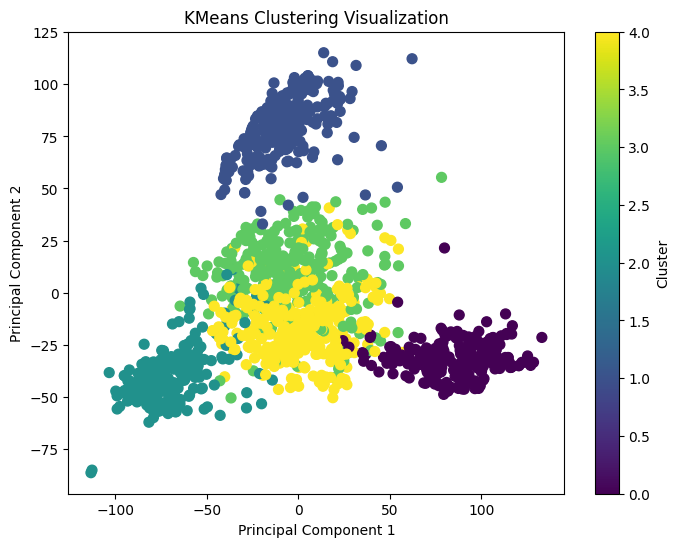

In [111]:
import matplotlib.pyplot as plt

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('KMeans Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
